In [4]:
import pandas as pd

In [5]:
import numpy as np

In [6]:
import recursive_lengths as rl

In [7]:
import minimize_lengths as mn

In [8]:
import imp

In [91]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [329]:
dglu = pd.read_csv('/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glucose.csv')

In [644]:
1/0.035

28.57142857142857

In [206]:
nump = dglu.groupby('cell').apply(lambda x: x['time_sec'].shape[0]) 

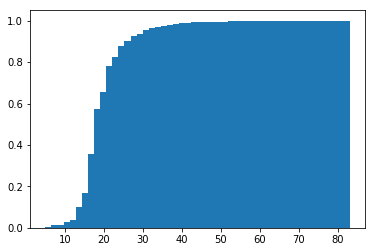

In [211]:
co= plt.hist(nump,density=1,cumulative=True,bins=50)

In [239]:
from scipy.stats import linregress

In [244]:
0.0001954569546277839*60

0.011727417277667034

In [114]:
df_tog = rl.give_unique_dataset(dglu,3,12)
_,in_dic = rl.build_data_strucutre(df_tog,'length_um',1)

In [113]:
print(in_dic['sd2'],in_dic1['sd2'])

0.0044004083032988745 0.0045480425217745545


In [116]:
print(in_dic['sd2'],in_dic1['sd2'])

0.012148897902034517 0.012289865915851572


In [128]:
1/(0.01422341+0.00031825)

68.76793983630479

In [120]:
np.linspace(0.007,0.018,10)

array([0.007     , 0.00822222, 0.00944444, 0.01066667, 0.01188889,
       0.01311111, 0.01433333, 0.01555556, 0.01677778, 0.018     ])

In [115]:
df_tog1 = rl.give_unique_dataset(dglu,4,12)
_,in_dic1 = rl.build_data_strucutre(df_tog1,'length_um',1)

In [94]:
in_dic.keys()

dict_keys(['dat_v', 'vec_dat_v', 'reind_v', 'dt', 'sd2', 'val_v', 'grad_matS', 'sm2', 'lane_ID_v', 'n_point', 's', 'S', 'rescale'])

In [301]:
np.sqrt(0.0036)

0.06

In [87]:
np.sum(np.hstack(df_tog.groupby('cell')['time_sec'].apply(lambda x: np.diff(x)/60).values)!=9)

0

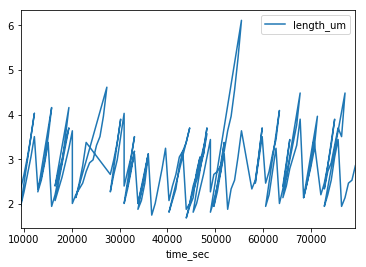

In [105]:
df_tog1.loc[df_tog1['lane_ID']=='myframes_chr_hi1_glucose_20190515_0_02'].plot(x='time_sec',y='length_um')


In [66]:
import matplotlib.pyplot as plt

In [24]:
def denoised_dataset(df,step,nump=3):
    """Try to obtain a dataset without noise by sampling every <<step>> """
    # At least nump cell per cell
    #df = df.groupby('cell').filter(lambda x: True if len(x['time_sec'])>nump*step else False)
    df = df.reset_index()
    ret = [] 
    for tau in range(step):
        tmp = np.sort(df['time_sec'].unique())[tau:][::step]
        dfsh = pd.concat([df.loc[df['time_sec']==k] for k in tmp])
        dfsh = dfsh.sort_index().reset_index()
        ret.append(dfsh)
        #ret.append(tmp)
    return ret

In [25]:
re = [dd for dd in denoised_dataset(dglu,step=3,nump=3)]

In [26]:
[r.shape for r in re]

[(24842, 67), (24784, 67), (24798, 67)]

In [31]:
[r.shape for r in re]

[(24568, 67), (24519, 67), (24536, 67)]

In [23]:
24568+ 24519+24536

73623

In [1196]:
set(dglu.time_sec.unique())-set(np.hstack([r.time_sec.unique() for r in re]))

{7380.0, 7560.0, 7920.0, 8100.0, 8460.0, 8640.0}

In [1141]:
in_dic1['s']

array([[0.70430392],
       [0.01120599]])

In [138]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [321]:
M= rl.hessian_1cc(in_dic['dat_v'][0][0][1][0],0.011,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[0]


In [329]:
def sy(x):
    return np.all(x==x.T)

In [435]:
def pos_and_sy(x):
    return np.linalg.eigvals(np.linalg.inv(-x))

In [416]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [957]:
def hessian_1cc(stop,W,mlam,gamma,sl2,sm2,dt,s,S,grad_matS,rescale,sd2):
    """grad and Hessian 1 cell cycle"""
    ##### likelihood and gradient at initial conditions
    gll,hll = rl.hessian_log_likelihood(W[0,0],s,S,sm2,grad_matS)
    #### Initialize parameters for recurrence
    F, A, a = rl.parameters(gamma,dt,mlam,sl2)
    grad_param = rl.hessian_parameters(gamma,dt,mlam,sl2)
    ##### P(z_0|x_0^m)
    b,B = rl.posteriori_matrices(W[0,0],s,S,sm2)
    grad_mat_b = rl.hessian_posteriori_matrices(W[0,0],s,S,sm2,grad_matS)
    it=0
    for j in range(1,W.shape[1]):
        ###### P(z_{t+dt}|D_t) = N(m,Q))
        if stop==it:
            return gll,hll
        it+=1
        m,Q = rl.new_mean_cov(b,B,F,A,a)
        grad_mat_Q = rl.hessian_new_mean_cov(b,B,F,A,a,grad_param,grad_mat_b)
        ##### P(z_{t+dt}|D_{t+dt}) = N(b',B')
        b,B = rl.posteriori_matrices(W[0,j],m,Q,sm2)
        grad_mat_b = rl.hessian_posteriori_matrices(W[0,j],m,Q,sm2,grad_mat_Q)
        ##### Likelihood
        G,H = rl.hessian_log_likelihood(W[0,j],m,Q,sm2,grad_mat_Q)
        gll+=G; hll=+H
    # Predict for daughter cell
    m,Q = rl.new_mean_cov(b,B,F,A,a)
    grad_mat_Q = rl.hessian_new_mean_cov(b,B,F,A,a,grad_param,grad_mat_b)
    # Find next cell initial conditions (9% asym div)
    s, S, grad_matS = rl.hess_cell_division_likelihood(m,Q,grad_mat_Q,sd2,rescale)
    return hll, gll, s, S, grad_matS

In [1044]:
def obj_and_grad_1cc(stop,W,mlam,gamma,sl2,sm2,dt,s,S,grad_matS,rescale,sd2):
    """Objective and gradient over 1 cell cycle"""
    ##### likelihood and gradient at initial conditions
    ll = rl.log_likelihood(W[0,0],s,S,sm2)
    gll = rl.grad_log_likelihood(W[0,0],s,S,sm2,grad_matS)
    #### Initialize parameters for recurrence
    F, A, a = rl.parameters(gamma,dt,mlam,sl2)
    grad_param = rl.grad_parameters(gamma,dt,mlam,sl2)
    ##### P(z_0|x_0^m)
    b,B = rl.posteriori_matrices(W[0,0],s,S,sm2)
    grad_mat_b = rl.grad_posteriori_matrices(W[0,0],s,S,sm2,grad_matS)
    it=0
    for j in range(1,W.shape[1]):
        ###### P(z_{t+dt}|D_t) = N(m,Q))
        m,Q = rl.new_mean_cov(b,B,F,A,a)
        grad_mat_Q = rl.grad_new_mean_cov(b,B,F,A,a,grad_param,grad_mat_b)
        ##### P(z_{t+dt}|D_{t+dt}) = N(b',B')
        b,B = rl.posteriori_matrices(W[0,j],m,Q,sm2)
        grad_mat_b = rl.grad_posteriori_matrices(W[0,j],m,Q,sm2,grad_mat_Q)
        if it==stop:
            return ll,gll
        it+=1
        ##### Likelihood
        ll += rl.log_likelihood(W[0,j],m,Q,sm2)
        gll += rl.grad_log_likelihood(W[0,j],m,Q,sm2,grad_mat_Q)

    # Predict for daughter cell
    m,Q = rl.new_mean_cov(b,B,F,A,a)
    grad_mat_Q = rl.grad_new_mean_cov(b,B,F,A,a,grad_param,grad_mat_b)
    # Find next cell initial conditions (9% asym div)
    s, S, grad_matS = rl.cell_division_likelihood_and_grad(m,Q,grad_mat_Q,sd2,rescale)
    return -ll, -gll, s, S, grad_matS

In [959]:
H,G,_,_,_ = hessian_1cc(10000,in_dic['dat_v'][0][0][1][0],0.011,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)
ll,g,_,_,_ = rl.obj_and_grad_1cc(in_dic['dat_v'][0][0][1][0],0.011,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)

In [1080]:
np.sqrt(7.065722364138041e-08)

0.00026581426530827954

In [1081]:
np.sqrt(6.693608914401874e-08)

0.0002587200980674264

In [1071]:
np.meshgrid(np.arange(0,2,1),np.arange(0,2,1),np.arange(0,2,1))

[array([[[0, 0],
         [1, 1]],
 
        [[0, 0],
         [1, 1]]]), array([[[0, 0],
         [0, 0]],
 
        [[1, 1],
         [1, 1]]]), array([[[0, 1],
         [0, 1]],
 
        [[0, 1],
         [0, 1]]])]

In [1072]:
def check_with_stop(stop):
    _,H = hessian_1cc(stop,in_dic['dat_v'][0][0][1][0],0.011,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)
    dgm = lambda x:obj_and_grad_1cc(stop,in_dic['dat_v'][0][0][1][0],x,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
    dgg = lambda x:obj_and_grad_1cc(stop,in_dic['dat_v'][0][0][1][0],0.01,x,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
    dgs = lambda x:obj_and_grad_1cc(stop,in_dic['dat_v'][0][0][1][0],0.01,0.011,x,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
    dge = lambda x:obj_and_grad_1cc(stop,in_dic['dat_v'][0][0][1][0],0.01,0.011,1e-07,x,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
    return np.hstack([derivative(dgm,0.01,dx=1e-10),derivative(dgg,0.011,dx=1e-9),derivative(dgs,1e-07,dx=1e-10),derivative(dge,1e-04,dx=1e-10)]),H
    

In [1074]:
check_with_stop(1)

(array([[-8.19954771e+00,  9.61321756e+02, -3.85144397e+05,
         -8.62838472e+04],
        [ 9.61969913e+02,  7.79196219e+00, -1.55991676e+05,
          5.93019463e+04],
        [-3.50845949e+05, -1.58433628e+05, -1.43144744e+10,
         -3.20546972e+09],
        [-7.84238364e+04,  5.93061013e+04, -3.20546972e+09,
         -7.20689269e+08]]),
 array([[-8.19956613e+00,  9.60342040e+02, -3.50548840e+05,
         -7.83567958e+04],
        [ 9.60342040e+02,  7.02891482e+00, -1.89943445e+05,
          5.15336895e+04],
        [-3.50548840e+05, -1.89943445e+05, -1.43259740e+10,
         -3.20082447e+09],
        [-7.83567958e+04,  5.15336895e+04, -3.20082447e+09,
         -7.18027511e+08]]))

In [1050]:
m=0.011;g=0.01
dm = lambda x :rl.obj_and_grad_1cc(in_dic['dat_v'][0][0][1][0],x,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[0]
dg = lambda x :rl.obj_and_grad_1cc(in_dic['dat_v'][0][0][1][0],m,x,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[0]

ddg = lambda x :rl.obj_and_grad_1cc(in_dic['dat_v'][0][0][1][0],m,x,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
ddm = lambda x :rl.obj_and_grad_1cc(in_dic['dat_v'][0][0][1][0],x,0.01,1e-07,1e-04,3,in_dic['s'],in_dic['S'],in_dic['grad_matS'],1,1e-03)[1]
print(derivative(dm,m,dx=1e-1,n=2))
print(derivative(dg,g,dx=1e-1,n=2))
print(derivative(ddm,m,dx=1e-1,n=1))
print(derivative(ddg,g,dx=1e-3,n=1))

2728.160152040753
11702.11288493411
[[ 2.72816015e+03]
 [-4.72673560e+04]
 [ 7.46751841e+08]
 [ 7.12518282e+05]]
[[-4.72674188e+04]
 [ 1.34203979e+04]
 [-1.66966369e+09]
 [-2.02170709e+06]]


In [ ]:
lm,gm = rl.grad_obj_wrap([0.011423,0.016071,2.363305e-07,0.000347],in_dic)

In [204]:
def hessian_and_grad_tot(x,in_dic):
    H = np.zeros((4,4)); G=np.zeros((4,1))
    mlam,gamma,sl2,sm2 = x
    reind_v,dat_v,grad_matS,s,S,dt,lane_ID_v,val_v,rescale,sd2 = in_dic['reind_v'],in_dic['dat_v'],in_dic['grad_matS'],in_dic['s'],in_dic['S'],in_dic['dt'],in_dic['lane_ID_v'],in_dic['val_v'],in_dic['rescale'],in_dic['sd2']
    for r,d in zip(reind_v,dat_v):
        Ht,Gt = rl.grad_obj_1lane(r,d,mlam,gamma,sl2,sm2,S,s,dt,grad_matS,rescale,sd2,False,rl.hessian_1cc)
        H+=Ht; G+=Gt 
    return H,G

In [252]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [253]:
g=0.01;dt=3;ml=0.011;sl2=1e-07
ret = rl.hessian_parameters(g,dt,ml,sl2)

In [246]:
de = lambda x: rl.hessian_parameters(x,dt,ml,sl2)['A_g']
de = derivative(de,g)

In [256]:
ret['A_g']

array([[-1.96920059e-06, -1.30364883e-06],
       [-1.30364883e-06, -8.64797200e-07]])

In [254]:
ret['A_gg']

array([[5.49093853e-06, 4.54646244e-06],
       [4.54646244e-06, 3.44182402e-06]])

In [260]:
ret['a_gm']

array([[4.41100445],
       [2.9113366 ]])

In [426]:
np.sqrt(in_dic['sd2'])

0.06637128452704208

In [427]:
np.arange(0.01,0.1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [434]:
for k in ['/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glucose.csv','/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glycerole.csv']:
    for j in ['3','4']:
        for v in np.arange(0.01,0.1,0.01):
            with open('/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/infparam/input_execute.txt', 'a') as file:
                file.write('python '+k+' '+j+' '+str(v**2)+'\n')

In [471]:
with open('/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/infparam/several_sd2/slurm-65182552.out','r') as file:
    a=file.readlines()
    print(a[0].replace('\n'," ")+)


In [475]:
a[1].find('sl2')

80

In [486]:
a[1][80:107]

"sl2': 9.752291935628766e-08"

In [540]:
import os

In [541]:
from os import listdir

In [ ]:
import glob

In [542]:
for file in glob.glob("*.txt"):

['Untitled.ipynb',
 'recursive_lengths.py',
 'run_minimization.py',
 'infparam',
 'execute_in_series.py',
 'activate.sh',
 '08012020_why_doesnt_work.ipynb',
 'input_execute.txt',
 '.ipynb_checkpoints',
 'stoch_proc.py',
 'input.txt',
 'jupiter_mathematica',
 'stoch_proc.pyc',
 'minimize_lengths.py',
 'recursive_lengths.pyc',
 '.gitignore',
 '__pycache__',
 '.git']

In [539]:
a[1][a[1].find('log_lik')+10:a[1].find('log_lik')+27]+a[1][a[1].find('mlam')+6:a[1].find('mlam')+27]+a[1][a[1].find('gamma')+8:a[1].find('gamma')+28]+a[1][a[1].find('sl2')+5:a[1].find('sl2')+27]+a[1][a[1].find('sm2')+5:a[1].find('sm2')+26]+a[0].replace('\n'," ")

'1.390241069082805 0.0051172723050653430.018372351180337868 9.752291935628766e-08 0.0006302325323894334 glycerol False 0.0036000000000000008 '

In [543]:
a[0]

'4 glycerol False 0.0036000000000000008\n'

In [520]:
a[1][a[1].find('mlam')+6:a[1].find('mlam')+27]

' 0.005117272305065343'

In [507]:
a[1][a[1].find('gamma')+8:a[1].find('gamma')+28]

'0.018372351180337868'

In [518]:
a[1][a[1].find('sl2')+5:a[1].find('sl2')+27]

' 9.752291935628766e-08'

In [514]:
a[1][a[1].find('sm2')+5:a[1].find('sm2')+26]

' 0.000630232532389433'

In [538]:
a[1][a[1].find('log_lik')+10:a[1].find('log_lik')+27]

'1.390241069082805'

In [561]:
import seaborn as sns

In [978]:
import pandas as pd

In [141]:
df = pd.read_csv('/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/infparam/severla_sd2/finals.txt',delim_whitespace=True)
#df['tau']=1/df['gamma']

In [1122]:
df.loc[(df['media']=='glucose')&(df['step']==4)]['sd2'].unique()

array([0.0055, 0.0075, 0.0045, 0.0025, 0.0095, 0.0085, 0.0065, 0.0035])

In [1121]:
np.arange(0.005,0.015,0.001)


array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 , 0.011, 0.012, 0.013,
       0.014])

In [235]:
df.loc[(df['medium']=='glucose')&(df['step']==4)].sort_values('ll')

,ll,mlam,gamma,sl2,sm2,step,medium,sd2,file
53,1.714624,0.011372,0.014682,2.067848e-07,0.000404,4,glucose,0.002500,slurm-65769822.out
50,1.714624,0.011372,0.014682,2.067848e-07,0.000404,4,glucose,0.002500,slurm-65769819.out
52,1.714624,0.011372,0.014682,2.067848e-07,0.000404,4,glucose,0.002500,slurm-65769821.out
51,1.714624,0.011372,0.014682,2.067848e-07,0.000404,4,glucose,0.002500,slurm-65769820.out
96,1.721055,0.011459,0.013927,2.000925e-07,0.000366,4,glucose,0.010000,slurm-65769867.out
97,1.721055,0.011459,0.013927,2.000964e-07,0.000366,4,glucose,0.010000,slurm-65769868.out
94,1.721055,0.011459,0.013927,2.000964e-07,0.000366,4,glucose,0.010000,slurm-65769865.out
93,1.721055,0.011459,0.013927,2.000964e-07,0.000366,4,glucose,0.010000,slurm-65769864.out
95,1.721055,0.011459,0.013927,2.000964e-07,0.000366,4,glucose,0.010000,slurm-65769866.out
89,1.723832,0.011457,0.013914,1.995949e-07,0.000367,4,glucose,0.009167,slurm-65769860.out


In [192]:
df.loc[(df['medium']=='glucose')&(df['step']==3)].sort_values('ll').iloc[-1]

ll                   1.89137
mlam               0.0114486
gamma              0.0159685
sl2              2.35017e-07
sm2               0.00034021
step                       3
medium               glucose
sd2               0.00583333
file      slurm-65769789.out
Name: 20, dtype: object

In [204]:
 1/( 0.013941794+0.0003)

70.21587308452854

In [203]:
1/( 0.015968-0.0003)

63.82435537401073

In [160]:
a=df_tog.loc[df_tog['cell']=='myframes_chr_hi1_glycerol_20190515_0_02207']
b=df_tog.loc[df_tog['cell']=='myframes_chr_hi1_glycerol_20190515_1_02207']
c=df_tog.loc[df_tog['cell']=='myframes_chr_hi1_glycerol_20190515_2_02207']

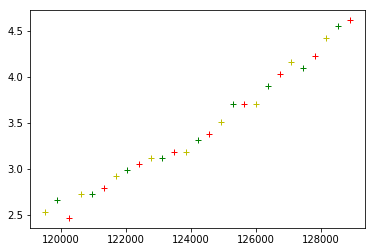

In [161]:
plt.plot(a['time_sec'],a['length_um'],'+g')
plt.plot(b['time_sec'],b['length_um'],'+r')
plt.plot(c['time_sec'],c['length_um'],'+y')

In [162]:
a1=df_tog1.loc[df_tog1['cell']=='myframes_chr_hi1_glycerol_20190515_0_02207']
b1=df_tog1.loc[df_tog1['cell']=='myframes_chr_hi1_glycerol_20190515_1_02207']
c1=df_tog1.loc[df_tog1['cell']=='myframes_chr_hi1_glycerol_20190515_2_02207']
d1=df_tog1.loc[df_tog1['cell']=='myframes_chr_hi1_glycerol_20190515_3_02207']

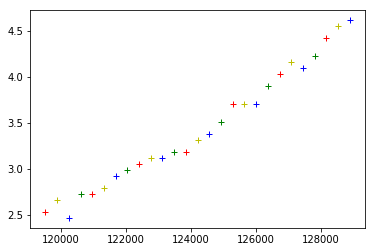

In [164]:
plt.plot(a1['time_sec'],a1['length_um'],'+g')
plt.plot(b1['time_sec'],b1['length_um'],'+r')
plt.plot(c1['time_sec'],c1['length_um'],'+y')
plt.plot(d1['time_sec'],d1['length_um'],'+b')

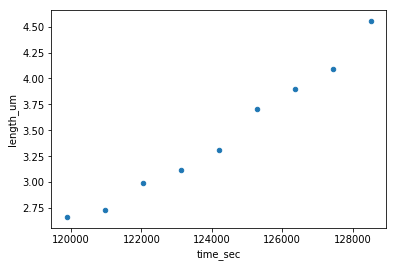

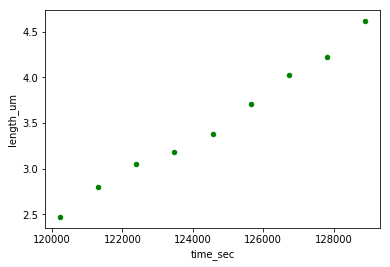

In [155]:
df_tog.loc[df_tog['cell']=='myframes_chr_hi1_glycerol_20190515_0_02207'].plot.scatter(x='time_sec',y='length_um')
df_tog.loc[df_tog['cell']=='myframes_chr_hi1_glycerol_20190515_1_02207'].plot.scatter(x='time_sec',y='length_um',c='g')

In [147]:
df_tog1.loc[]

array(['myframes_chr_hi1_glycerol_20190515_0_02171',
       'myframes_chr_hi1_glycerol_20190515_0_02174',
       'myframes_chr_hi1_glycerol_20190515_0_02181', ...,
       'myframes_chr_rpmB_glycerol_20190515_3_2513302',
       'myframes_chr_rpmB_glycerol_20190515_3_2513303',
       'myframes_chr_rpmB_glycerol_20190515_3_2513308'], dtype=object)

In [140]:
 4.603898341359448e-06, 'mlam': 1.8979281883480874e-05, 'gamma': 0.00035846835853571785, 'sl2': 2.075596211588895e-09

90.30976248532467

In [ ]:
1.652881	0.005452	0.013789	7.176430e-08	0.000480	3	glycerol	0.015556
1.487141	0.005446	0.011073	5.318072e-08	0.000529	4	glycerol	0.015556

In [1114]:
df.loc[(df['media']=='glycerol')&(df['step']==3)]['sd2'].unique()

array([0.017, 0.011, 0.014, 0.01 , 0.012, 0.013, 0.015, 0.019, 0.018,
       0.016])

In [1117]:
df.loc[(df['media']=='glycerol')&(df['step']==3)].sort_values('log_lik')

,log_lik,mlam,gamma,sl2,sm2,step,media,num,sd2,tau
363,1.640422,0.005461,0.013658,7.133863e-08,0.000496,3,glycerol,False,0.010,73.217060
282,1.640422,0.005461,0.013658,7.133851e-08,0.000496,3,glycerol,False,0.010,73.217186
48,1.640422,0.005461,0.013658,7.133849e-08,0.000496,3,glycerol,False,0.010,73.217202
158,1.640422,0.005461,0.013658,7.133851e-08,0.000496,3,glycerol,False,0.010,73.217187
12,1.640422,0.005461,0.013658,7.133850e-08,0.000496,3,glycerol,False,0.010,73.217193
21,1.640422,0.005461,0.013658,7.133850e-08,0.000496,3,glycerol,False,0.010,73.217192
211,1.640422,0.005461,0.013658,7.133852e-08,0.000496,3,glycerol,False,0.010,73.217173
243,1.640422,0.005461,0.013658,7.133851e-08,0.000496,3,glycerol,False,0.010,73.217185
197,1.640422,0.005461,0.013658,7.133851e-08,0.000496,3,glycerol,False,0.010,73.217186
50,1.640422,0.005461,0.013658,7.133851e-08,0.000496,3,glycerol,False,0.010,73.217186


In [ ]:
0.005471	0.013457	7.028141e-08	0.000492	

In [ ]:
0.005229	0.013264	6.124439e-08	0.000529

In [992]:
df['cv']=np.sqrt(df['sl2']/(2*df['gamma']))/df['mlam']

In [989]:
dfglu = df.loc[df['media']=='glucose']

In [583]:
import matplotlib.pyplot as plt

In [986]:
np.sqrt(0.005)

0.07071067811865475

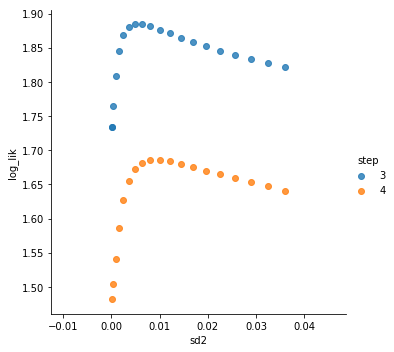

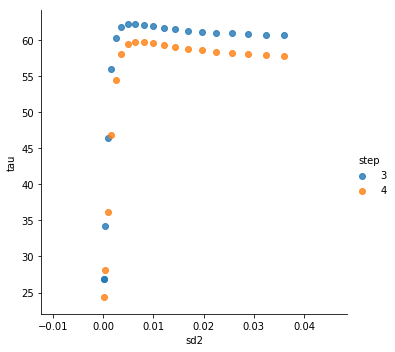

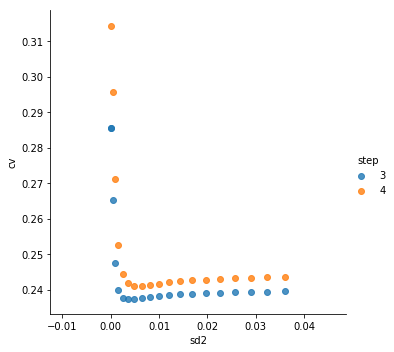

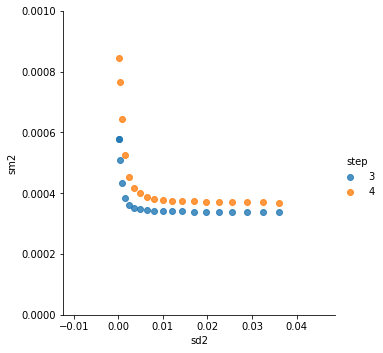

In [590]:
sns.lmplot( 'sd2','log_lik', data=dfglu, hue='step', fit_reg=False)
sns.lmplot( 'sd2','tau', data=dfglu, hue='step', fit_reg=False)
sns.lmplot( 'sd2','cv', data=dfglu, hue='step', fit_reg=False)
g=sns.lmplot( 'sd2','sm2', data=dfglu, hue='step', fit_reg=False)
g.set(ylim=(0, 0.001))

In [999]:
dfgly = df.loc[df['media']=='glycerol']
dfgly=dfgly.drop(index=45)

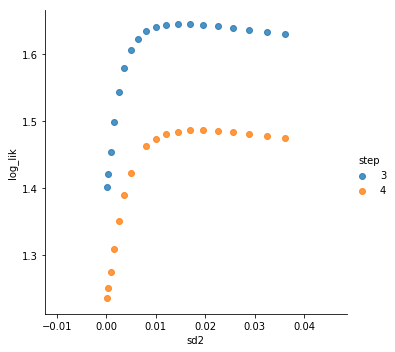

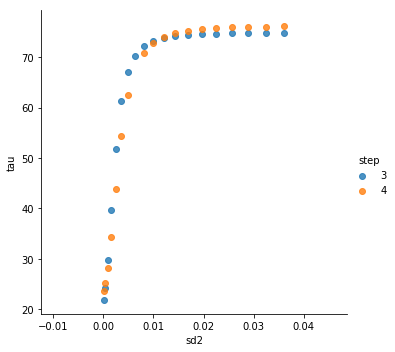

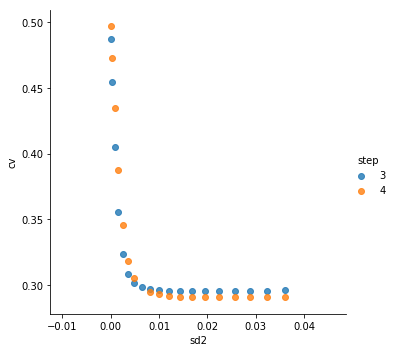

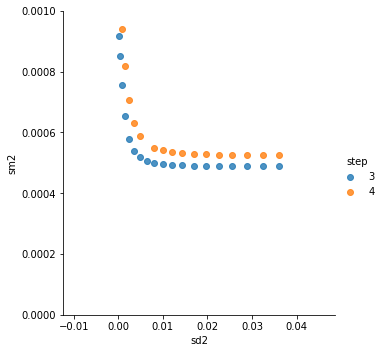

In [1000]:
sns.lmplot( 'sd2','log_lik', data=dfgly, hue='step', fit_reg=False)
sns.lmplot( 'sd2','tau', data=dfgly, hue='step', fit_reg=False)
sns.lmplot( 'sd2','cv', data=dfgly, hue='step', fit_reg=False)
g=sns.lmplot( 'sd2','sm2', data=dfgly, hue='step', fit_reg=False)
g.set(ylim=(0, 0.001))

In [1094]:
df.loc[(df['media']=='glucose')&(df['step']==3)].sort_values('log_lik')

,log_lik,mlam,gamma,sl2,sm2,step,media,num,sd2,tau,cv
74,1.734054,0.011057,0.037254,7.423872e-07,0.000577,3,glucose,False,0.0001,26.842417,0.285470
57,1.734054,0.011057,0.037254,7.423872e-07,0.000577,3,glucose,False,0.0001,26.842417,0.285470
27,1.764843,0.011132,0.029183,5.090504e-07,0.000510,3,glucose,False,0.0004,34.266967,0.265287
67,1.808058,0.011242,0.021536,3.331880e-07,0.000432,3,glucose,False,0.0009,46.434491,0.247408
34,1.821396,0.011458,0.016494,2.483662e-07,0.000339,3,glucose,False,0.0361,60.628423,0.239478
30,1.827242,0.011457,0.016474,2.478909e-07,0.000339,3,glucose,False,0.0324,60.703307,0.239408
11,1.833250,0.011457,0.016450,2.473461e-07,0.000339,3,glucose,False,0.0289,60.789031,0.239328
6,1.839410,0.011456,0.016424,2.467193e-07,0.000339,3,glucose,False,0.0256,60.887474,0.239235
52,1.845699,0.011455,0.016393,2.459958e-07,0.000339,3,glucose,False,0.0225,61.000801,0.239127
68,1.845821,0.011329,0.017894,2.642037e-07,0.000384,3,glucose,False,0.0016,55.886201,0.239827


In [1100]:
np.arange(0.0025,0.01,0.001)

array([0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075, 0.0085, 0.0095])

In [1009]:
dg = pd.read_csv('/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glycerole.csv')


In [1010]:
dg['log_len'] = np.log(dg['length_um'])

In [1006]:
dg.groupby('cell')['log_len'].first().mean()

0.6761003636437988

In [1011]:
dg.groupby('cell')['log_len'].first().mean()

0.661230159836278

In [1013]:
np.sqrt(0.014)/0.66

0.1792751449424126

In [1014]:
np.sqrt(0.019)/0.66

0.2088492235165185

In [1017]:
np.sqrt(0.0049)/(0.67)

0.10447761194029849

## 

In [258]:
degl = pd.read_csv('~/deep_moma_data/myframes_20190730_deepmoma_glucose.csv')

In [260]:
G=degl.groupby('cell').filter(lambda x: linregress(x['time_sec'],np.log(x['length_deep'])).rvalue>0.98)

In [262]:
degl.shape

(2424, 70)

In [261]:
G.shape

(2424, 70)

In [330]:
degly = pd.read_csv('/scicore/home/nimwegen/fiori/deep_moma_data/myframes_plac_chr_glucose_20190730.csv')

In [359]:
    file_to_analy = '/scicore/home/nimwegen/fiori/deep_moma_data/myframes_plac_chr_glucose_20190730.csv'
    dglu = pd.read_csv(file_to_analy)
    #dglu = dglu.loc[dglu.discard_top]
    #dglu = dglu.loc[dglu['end_type']=='div']

# Plot data

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

In [289]:
df = pd.read_csv('/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/infparam/legacy_5may.txt',delim_whitespace=True)
#Select the one with larger likelihod
idx = df.groupby(['file','step','length'])['log_lik'].transform(max)==df['log_lik']
df = df[idx]
#Change name
for k in df.index:
    if df.loc[k]['length'] == 'length_raw' and '_deepmoma_' in df.loc[k]['file']:
        df.loc[k,'length'] = 'length_box_deep'
    if df.loc[k]['length'] == 'length_raw' and '_legacymoma_' in df.loc[k]['file']:
        df.loc[k,'length'] = 'length_box_legacy'
#df = pd.read_csv('/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/infparam/5may_inference.txt',delim_whitespace=True)
#df.iloc[:,:10] = df.iloc[:,:10].astype('float64')
for k in ['log_lik','ml','gamma','sl2','sm2','sd2','eml','egamma','esm2','esd2','esl2']:
    df[k] = df[k].apply(lambda x: float(x))

In [260]:
df = df.drop([204])

In [290]:
df['file'] = df['file'].apply(lambda x: x.replace('/scicore/home/nimwegen/fiori/deep_moma_data/',''))
#df = df.loc[df['mincel']==12]
#df = df.loc[df['medium']!='nacl']
df['tau'] = 1/df['gamma']
df['etau'] = df['egamma']/df['gamma']**2
df['sm'] = np.sqrt(df['sm2'])
df['esm'] = 0.5/np.sqrt(df['sm2'])*df['esm2']
df['cv'] = np.sqrt(df['sl2']/(2*df['gamma']*df['ml']))
df['ecv'] = 0.5/np.sqrt(df['sl2']/(2*df['gamma']*df['ml']))*(df['esl2']/(2*df['gamma']*df['ml'])-df['sl2']/(2*df['gamma']**2*df['ml'])*df['egamma']-df['sl2']/(2*df['gamma']*df['ml']**2)*df['eml'])
df['sd'] = np.sqrt(df['sd2'])
df['esd'] = 0.5/np.sqrt(df['sd2'])*df['esd2']
df['sl'] = np.sqrt(df['sl2'])
df['esl'] = 0.5/np.sqrt(df['sl2'])*df['esl2']

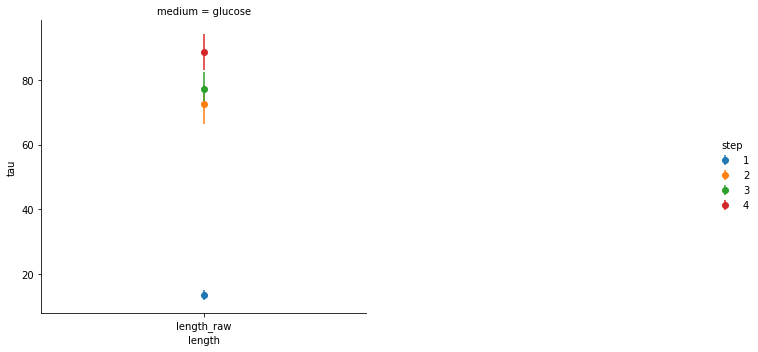

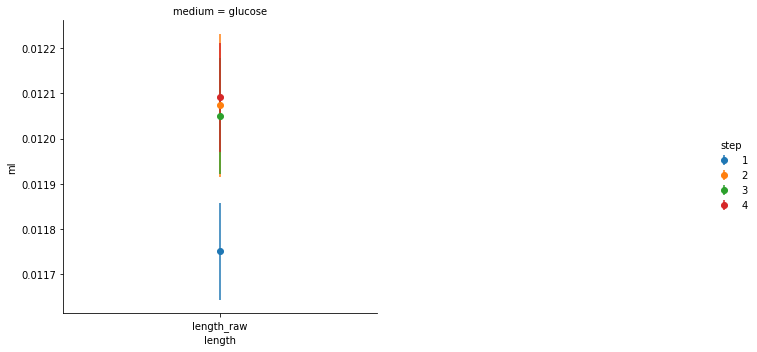

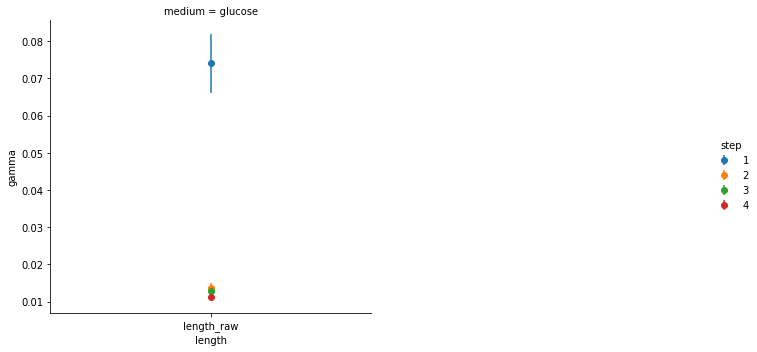

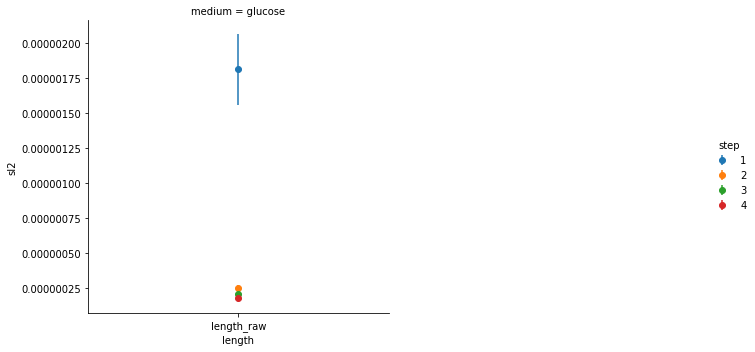

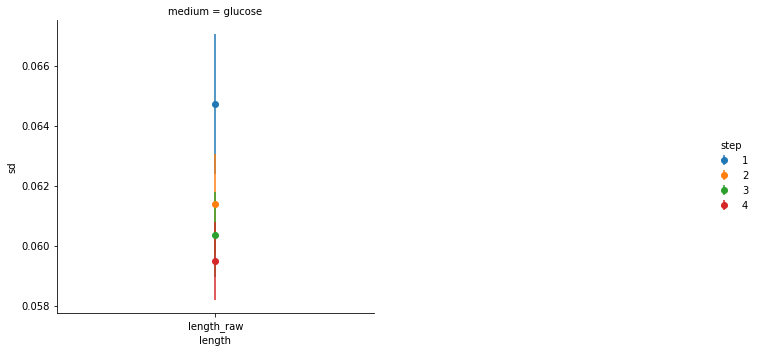

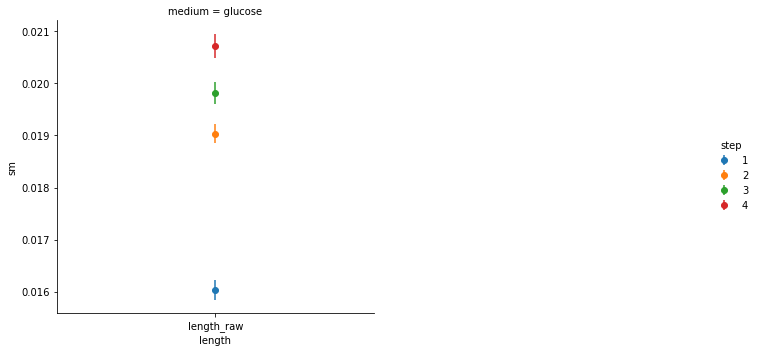

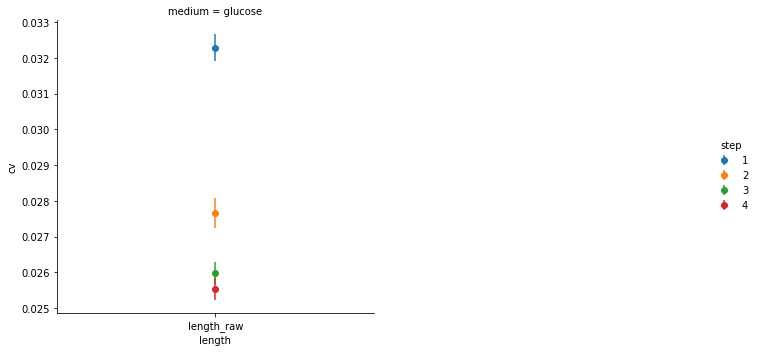

In [291]:
for k in ['tau','ml','gamma','sl2','sd','sm','cv']:
#for k in ['sl']:
    g = sns.FacetGrid(df, col="medium", size=5,hue="step",col_wrap=2,sharey=False)
    snspl = g.map(plt.errorbar, "length", "{}".format(k), "e{}".format(k),fmt='o').add_legend()
    snspl.savefig('{}_5mayr9.png'.format(k))

In [274]:
[np.sqrt(x) for x in [0.004227570958049784,0.00429098048006833,0.00440219846680521,0.0045490036995115]]



[0.06501977359272934,
 0.06550557594639048,
 0.06634906530468392,
 0.0674463023412811]

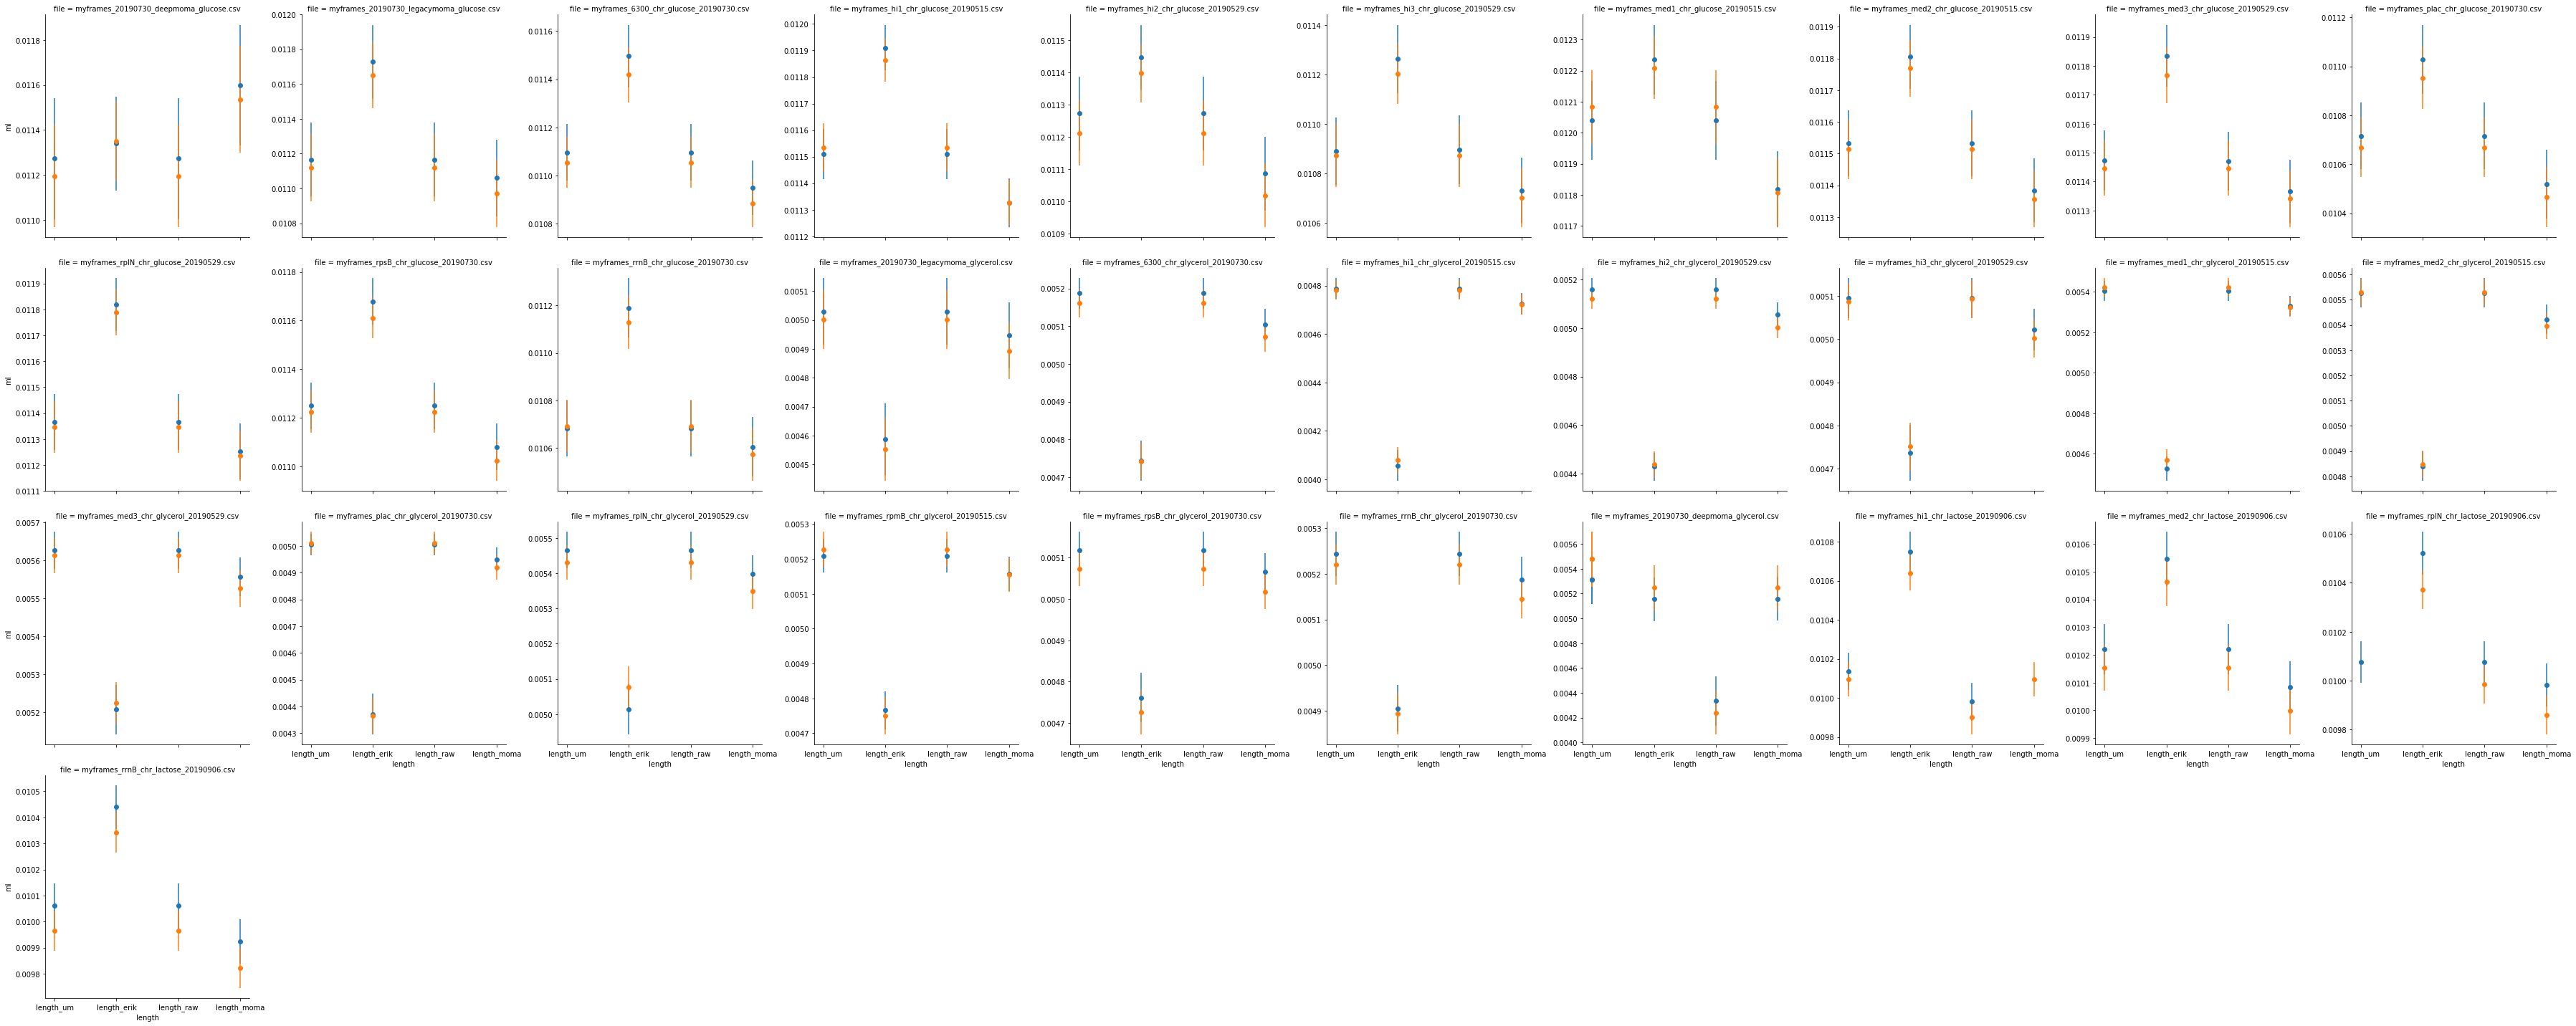

In [636]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,col_order=order,sharey=False)
snspl = g.map(plt.errorbar, "length", "ml", "eml",fmt='o')
snspl.savefig('mlamdep.png')

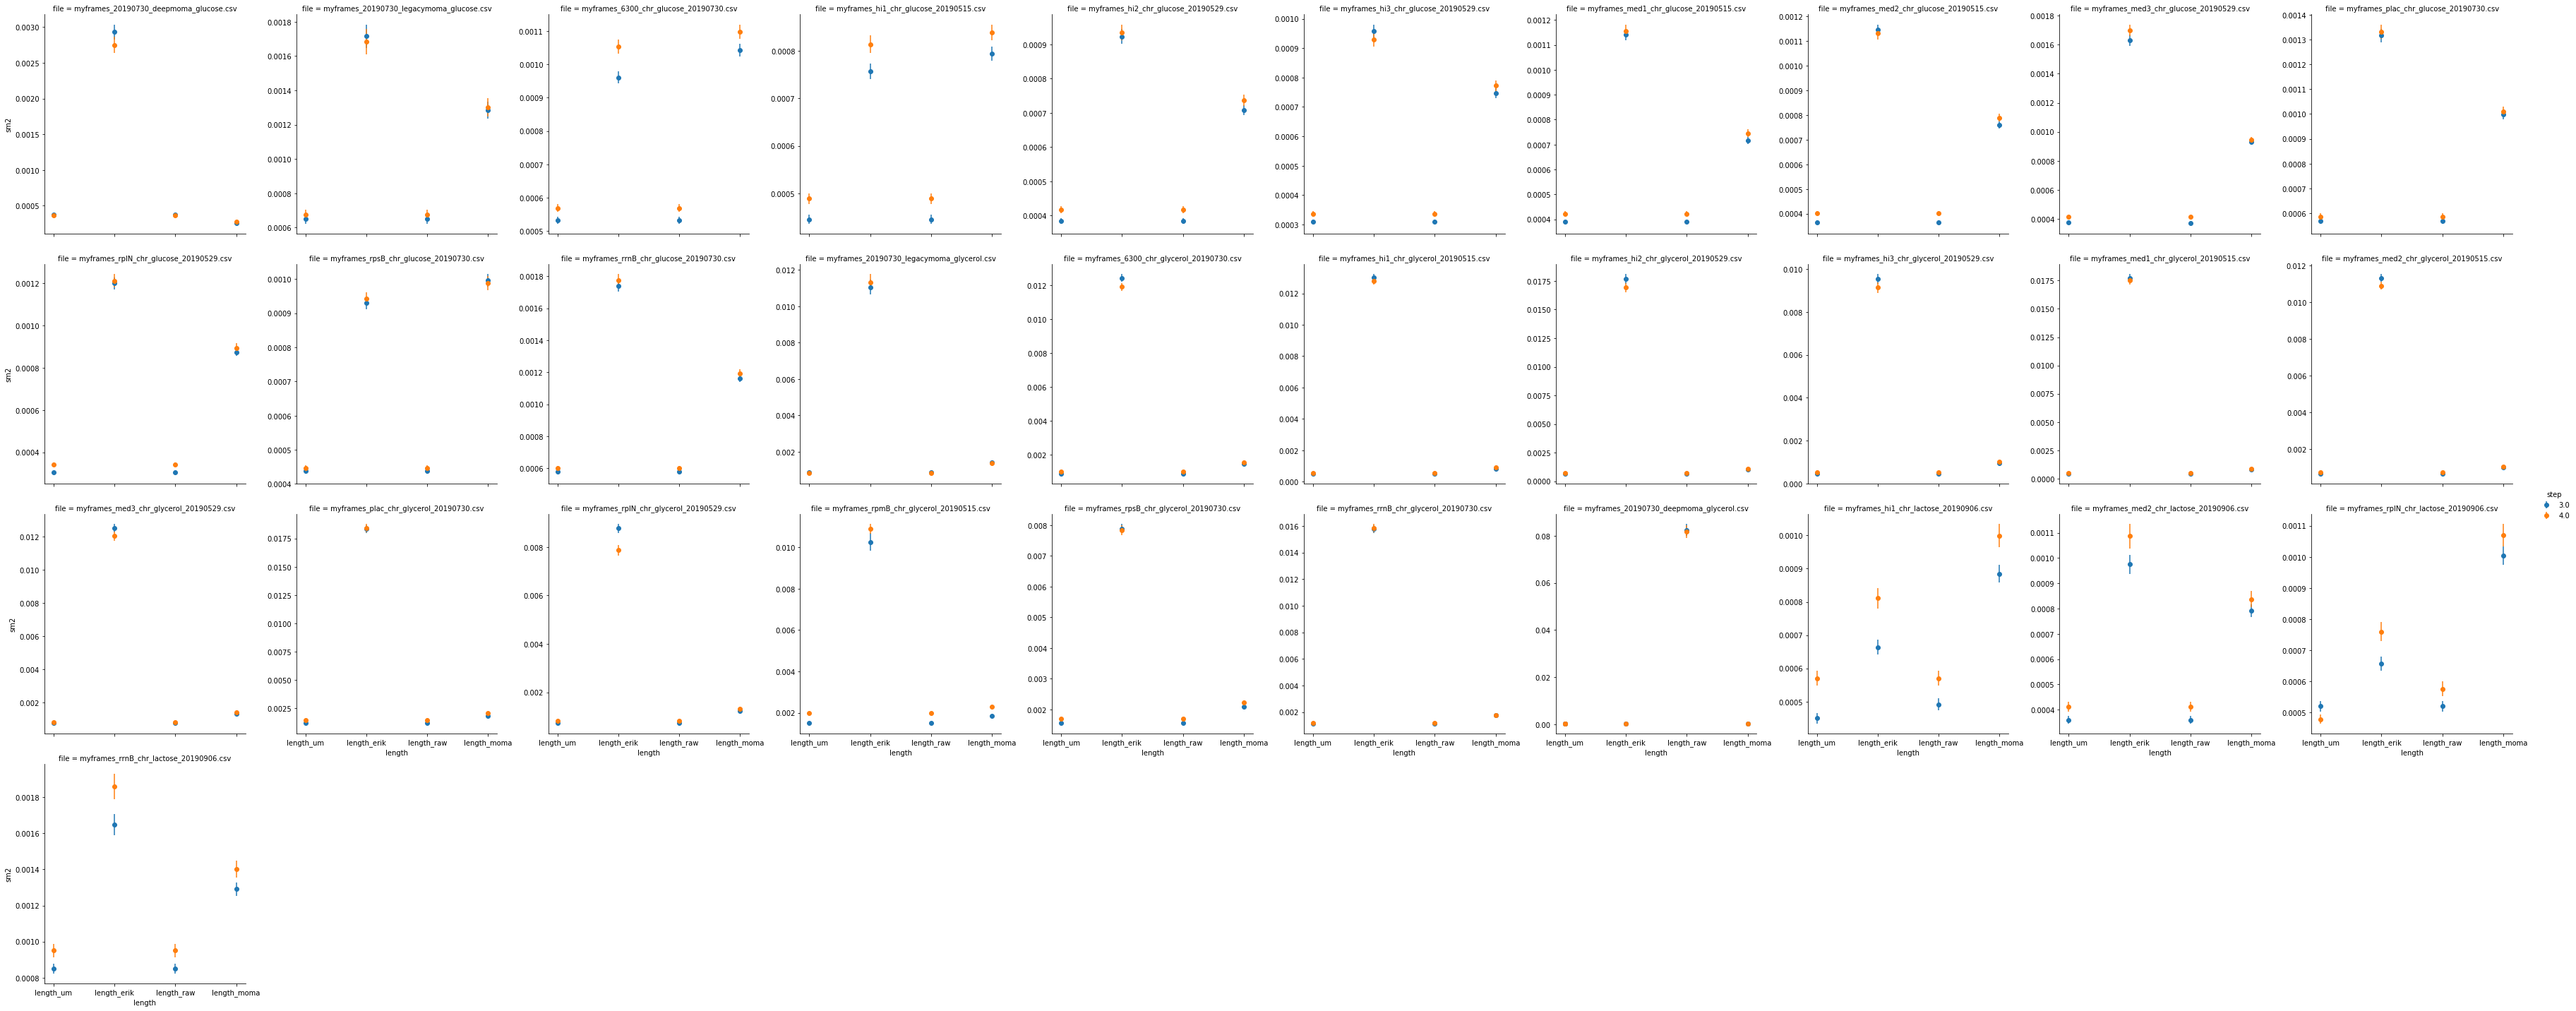

In [637]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,col_order=order,sharey=False)
snspl = (g.map(plt.errorbar, "length", "sm2", "esm2",fmt='o').add_legend())
snspl.savefig('sm2dep.png')

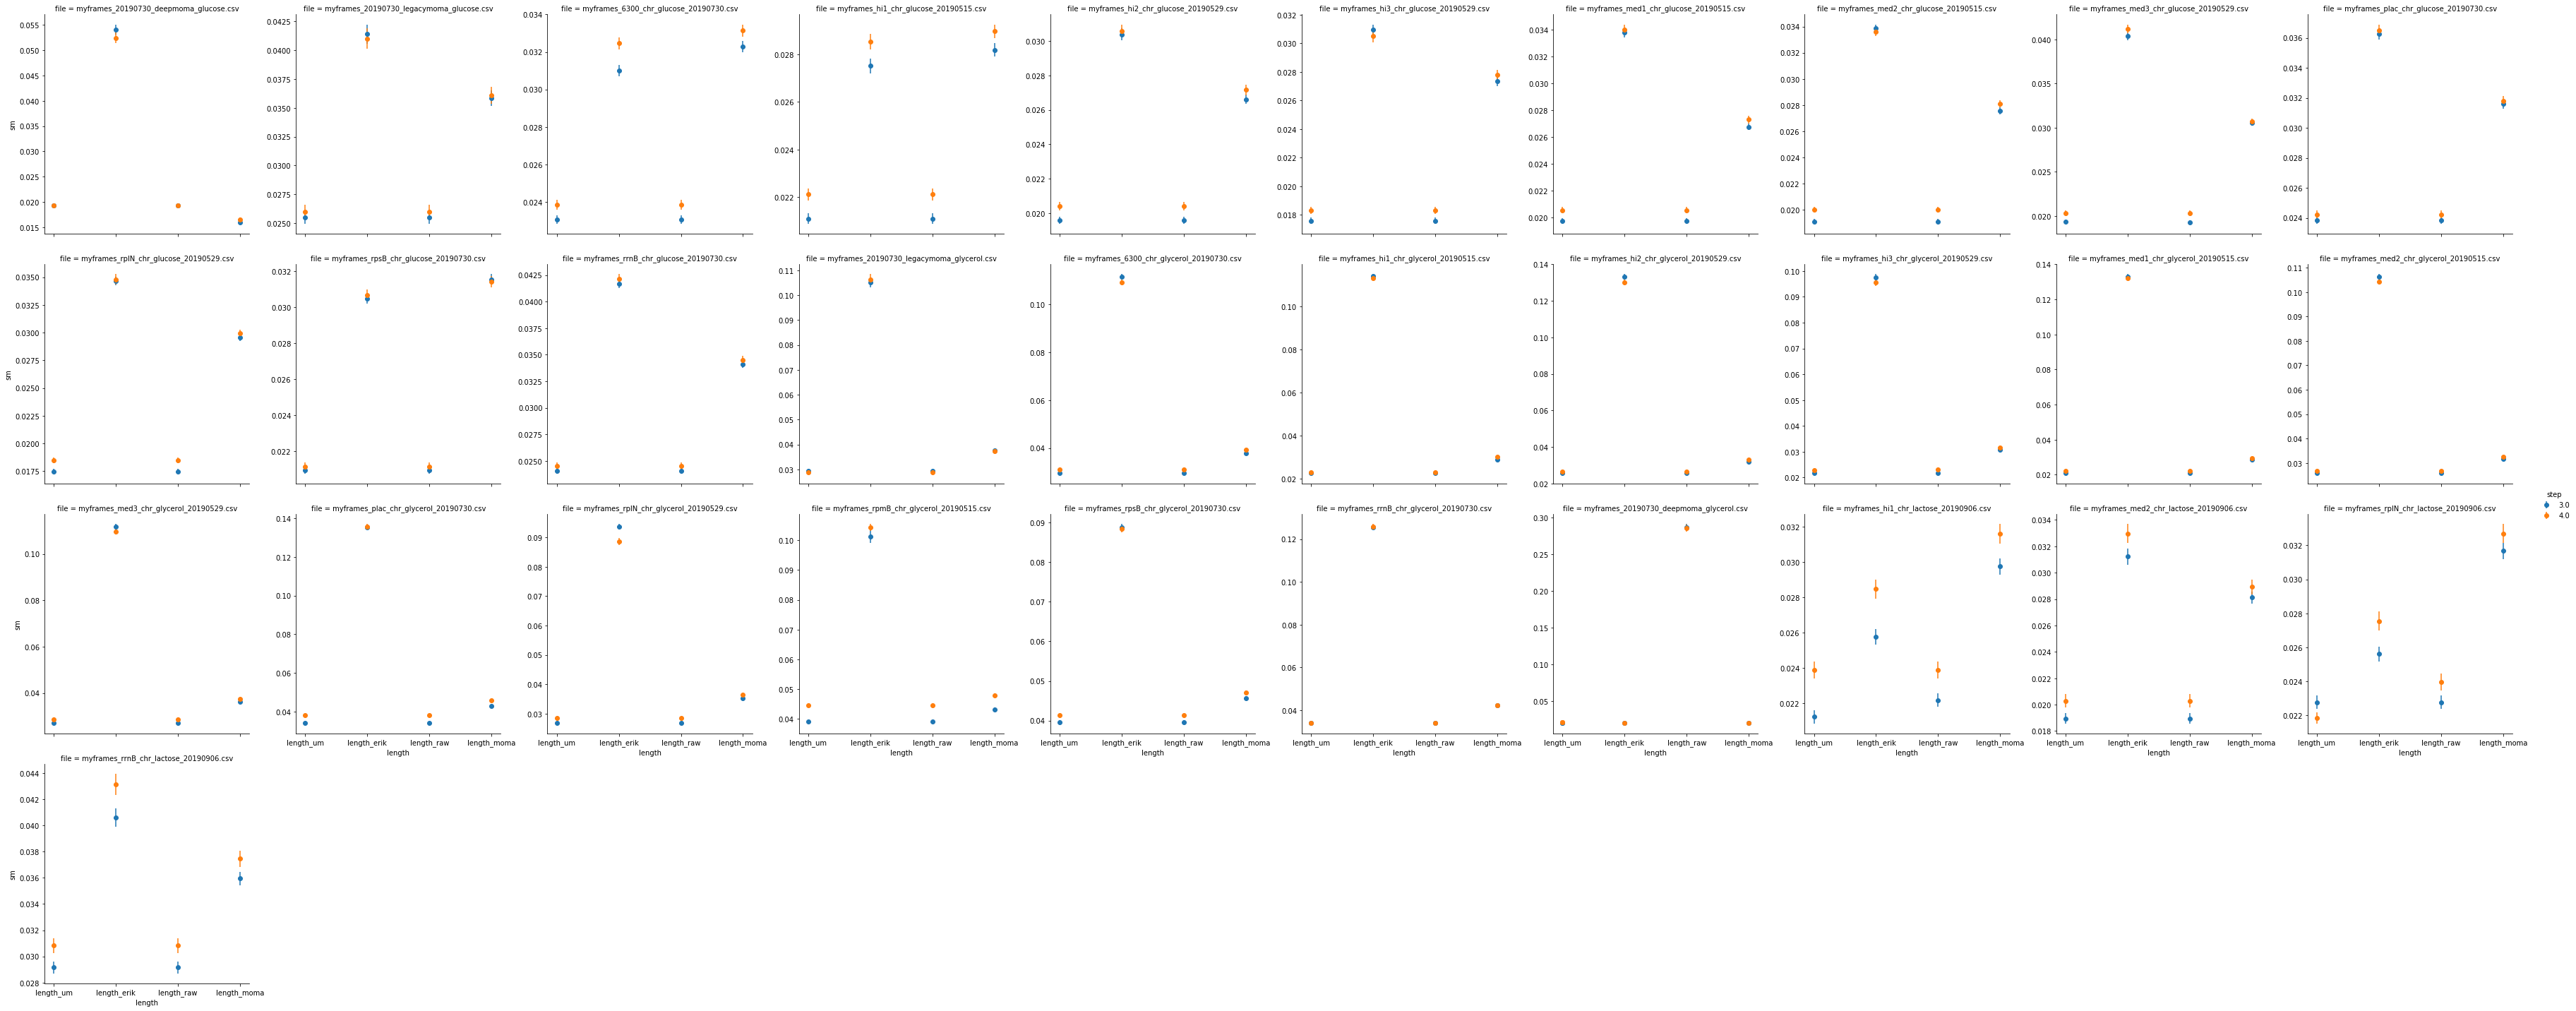

In [638]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,col_order=order,sharey=False)
snspl = (g.map(plt.errorbar, "length", "sm", "esm",fmt='o').add_legend())
snspl.savefig('smdep.png')

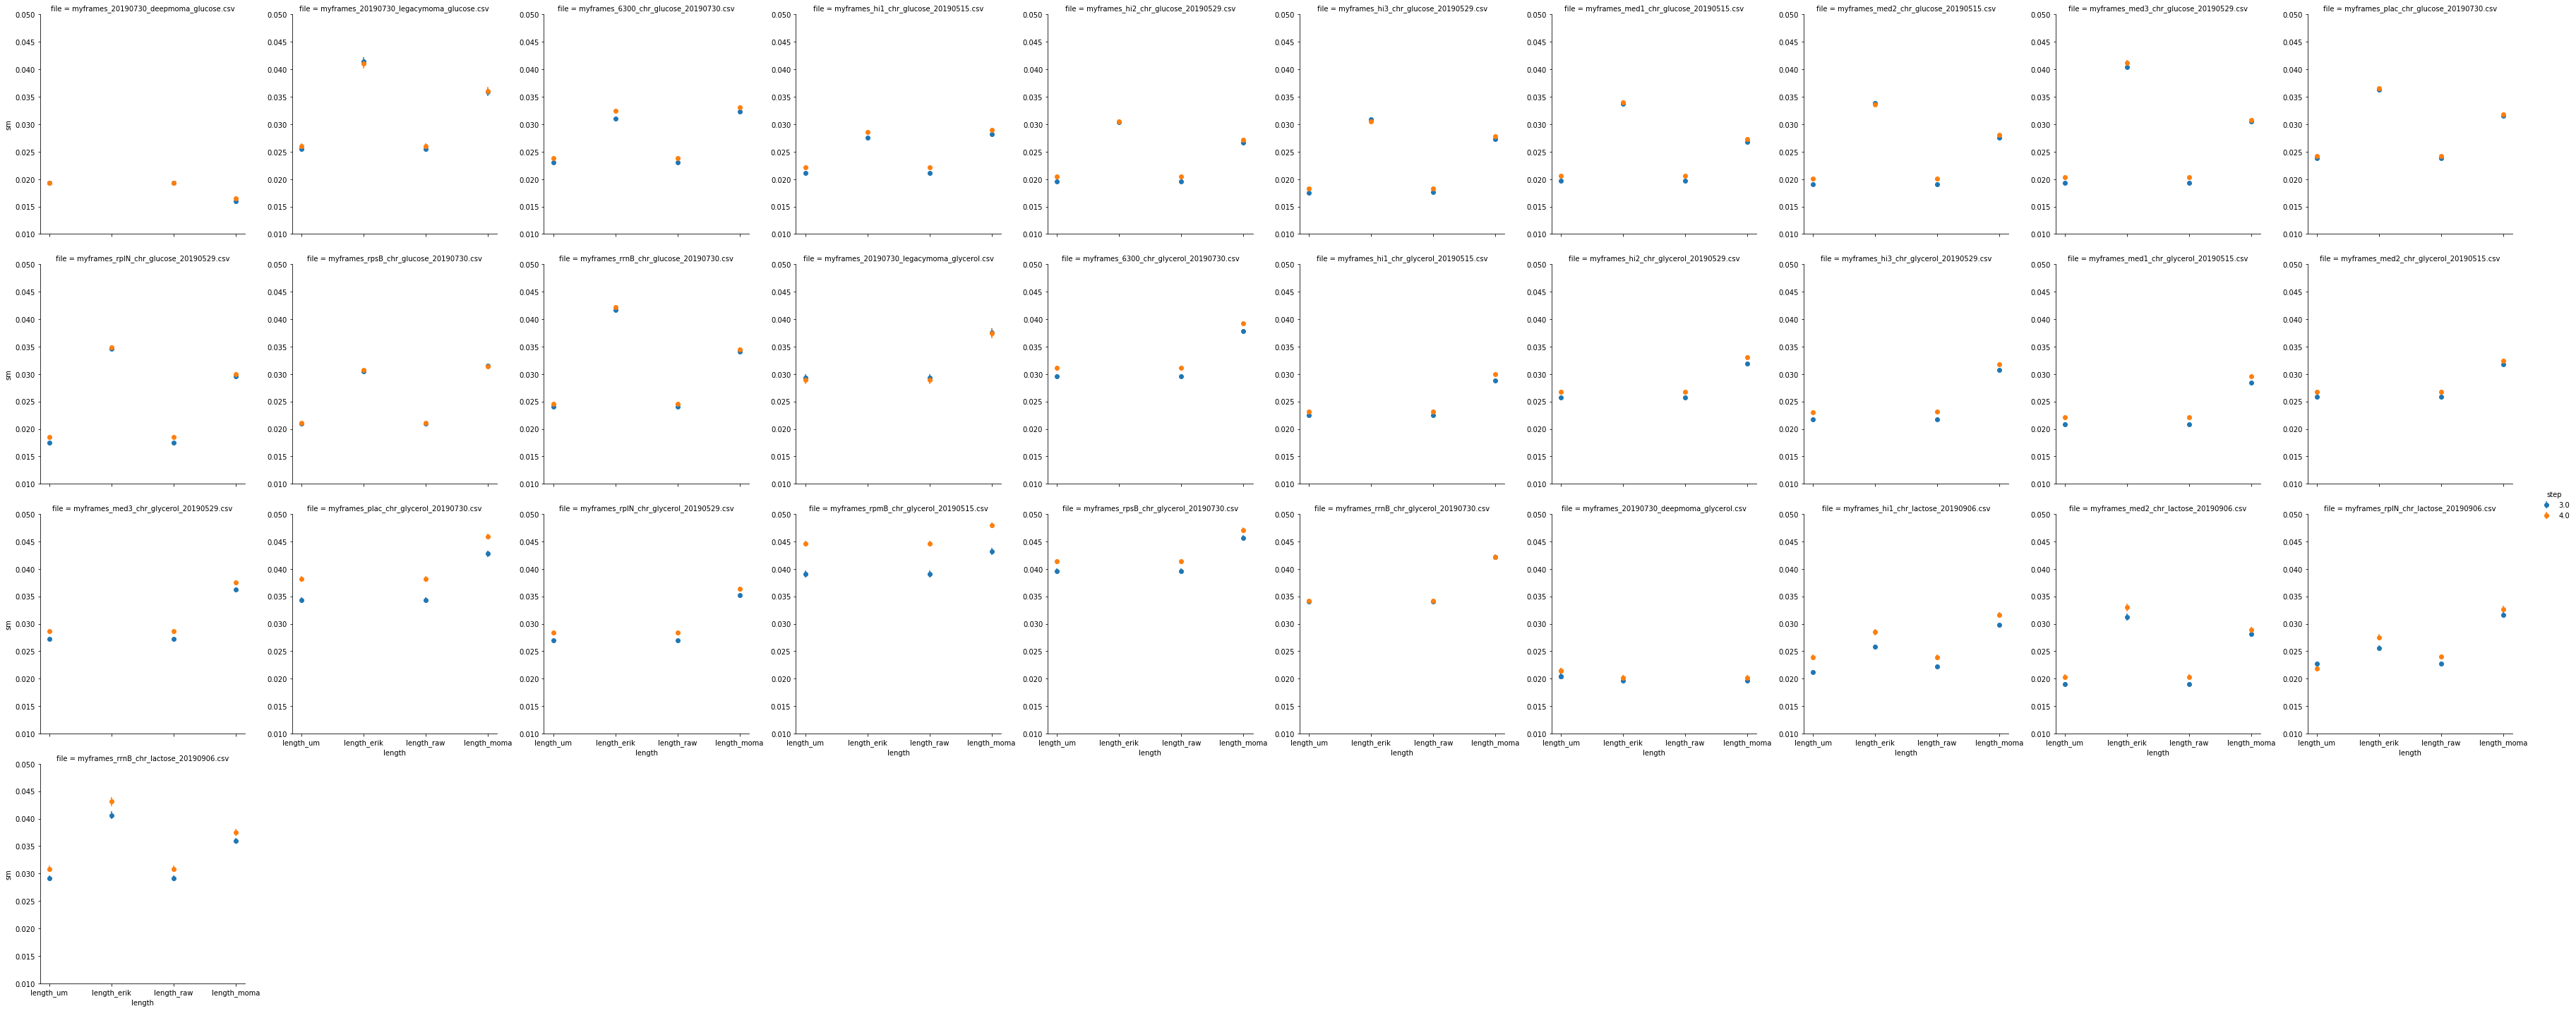

In [639]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,ylim=(0.01,0.05),col_order=order,sharey=False)
snspl = (g.map(plt.errorbar, "length", "sm", "esm",fmt='o').add_legend())
snspl.savefig('smdepylim.png')

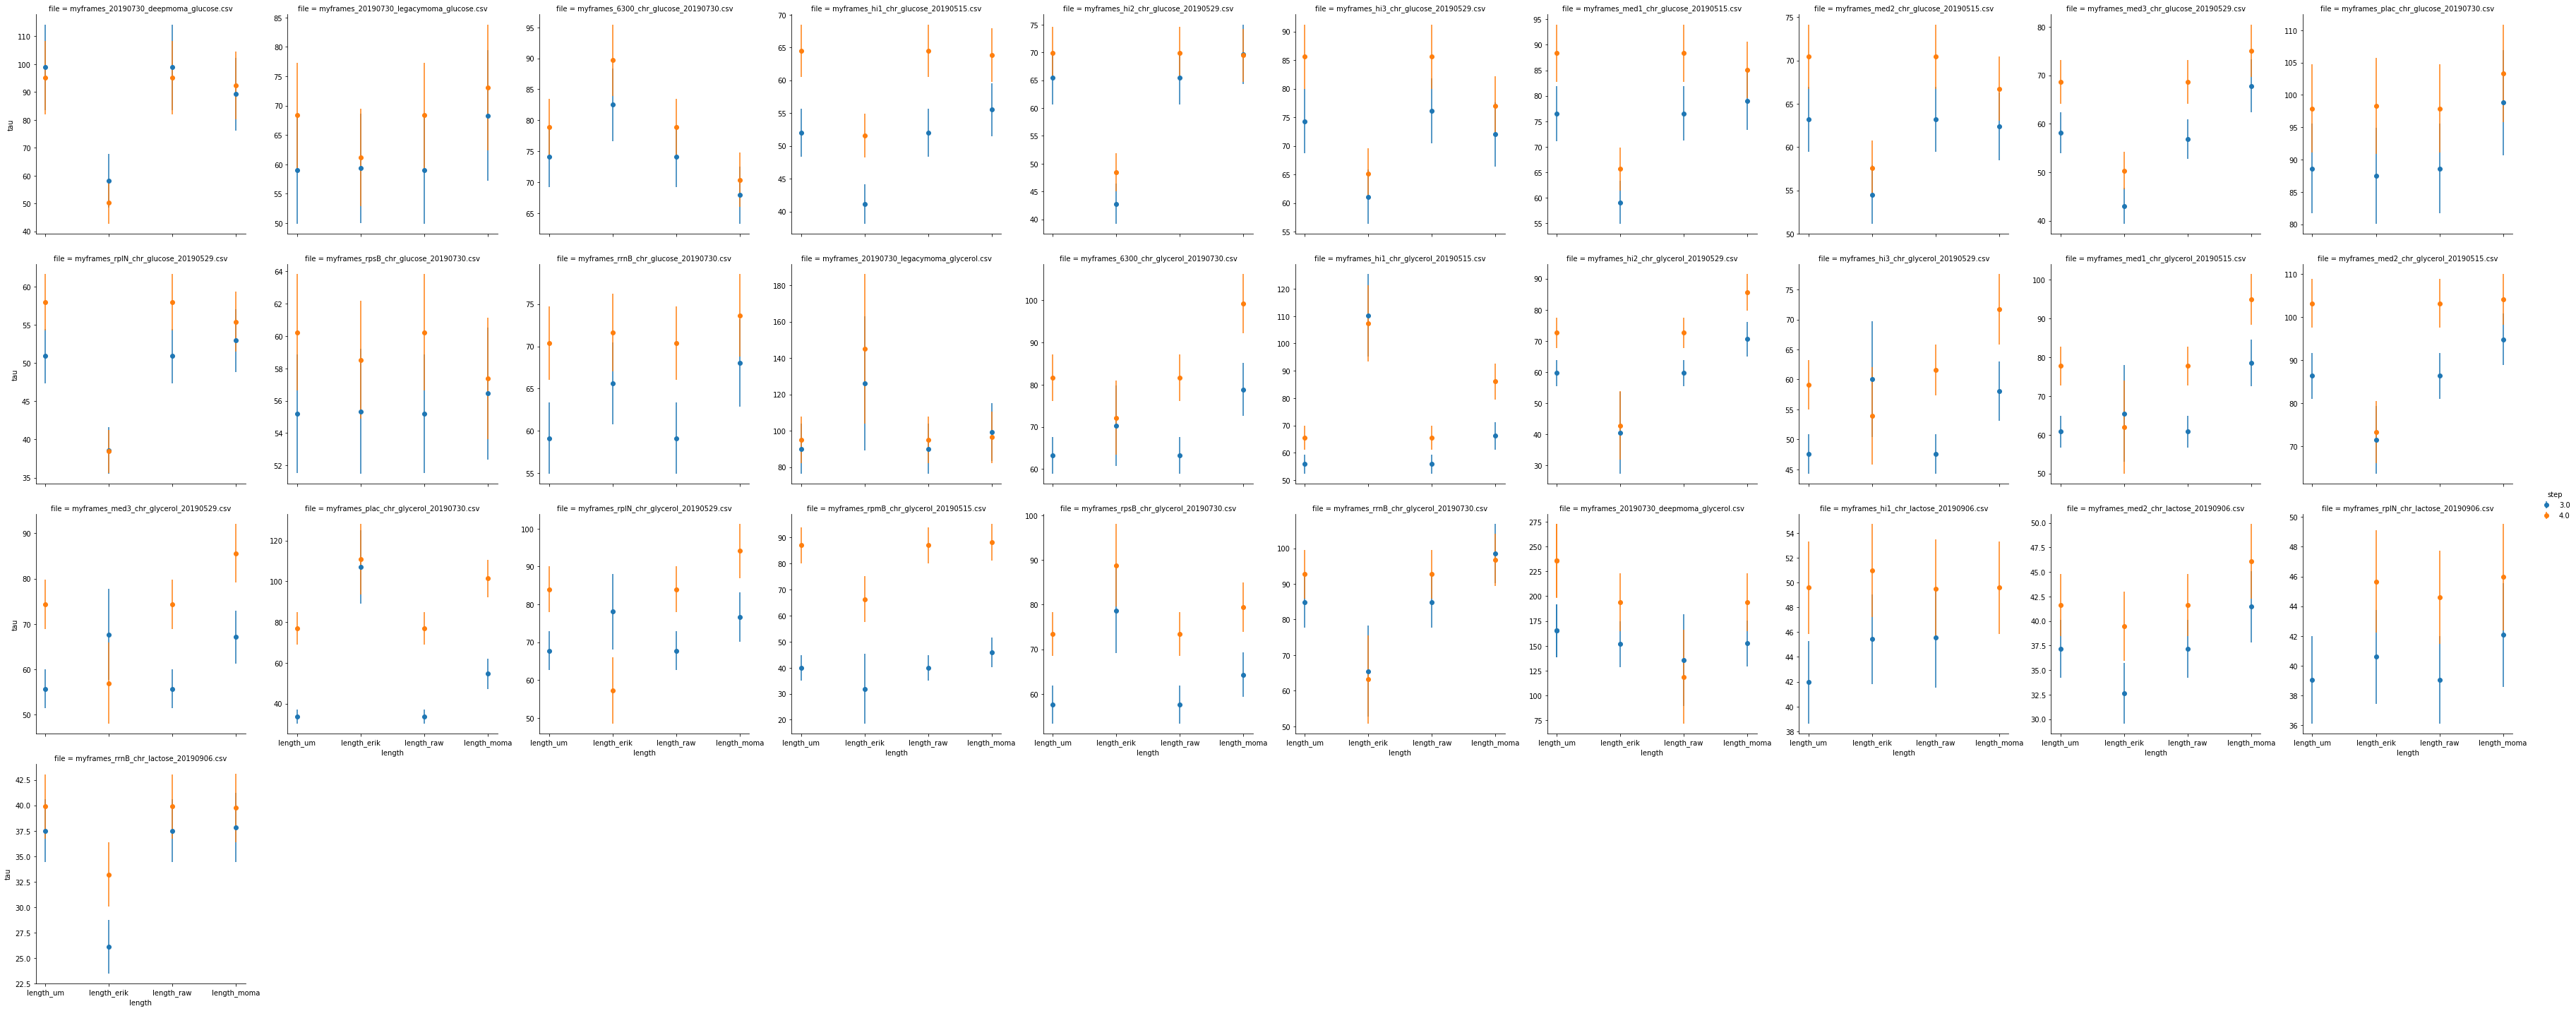

In [640]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,col_order=order,sharey=False)
snspl = (g.map(plt.errorbar, "length", "tau", "etau",fmt='o').add_legend())
snspl.savefig('taudep.png')

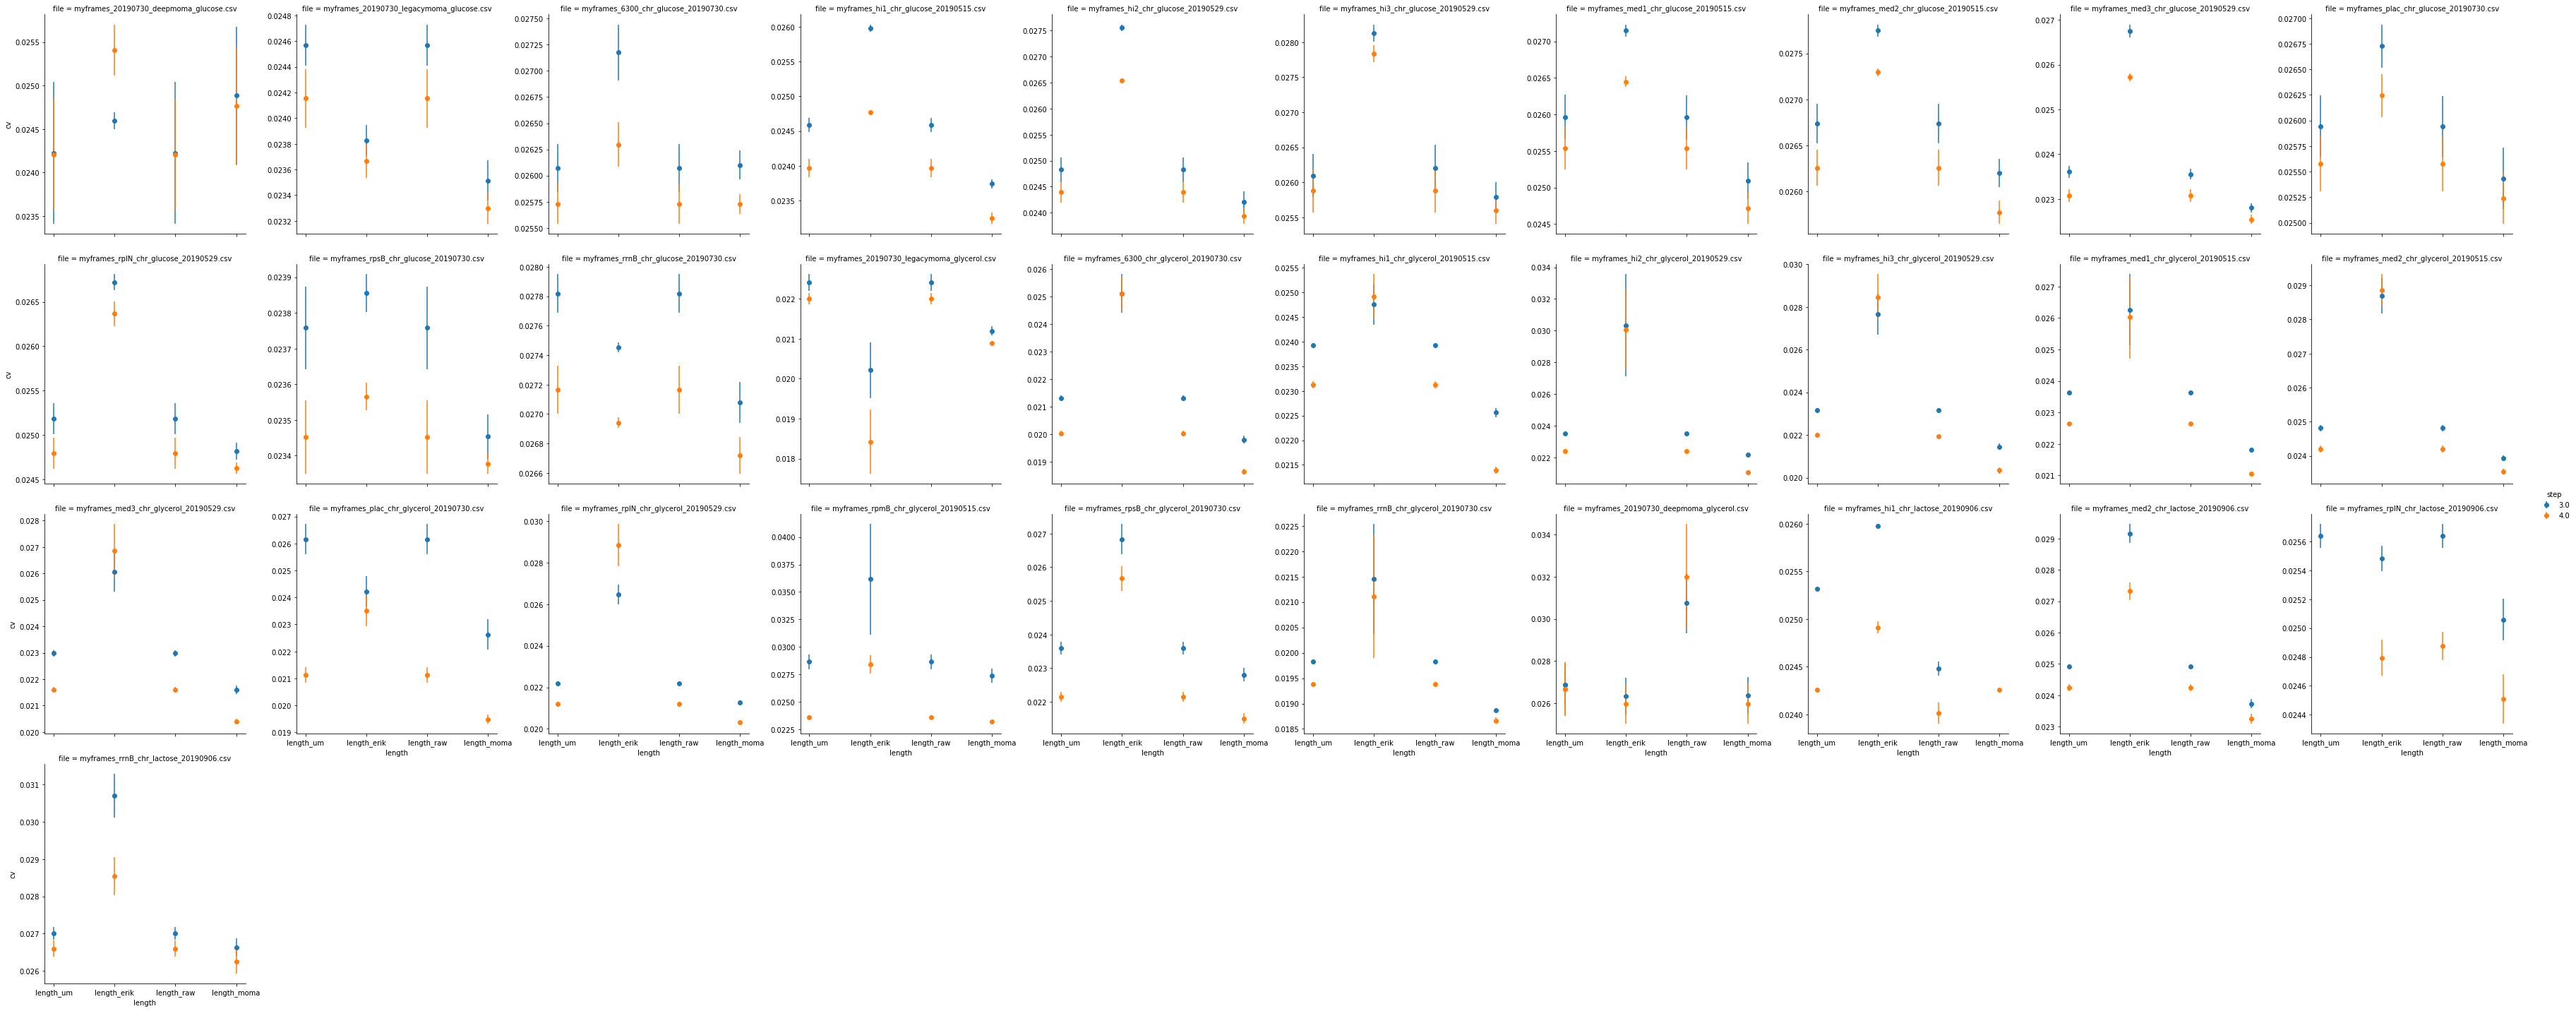

In [641]:
g = sns.FacetGrid(df, col="file", size=5,hue="step",col_wrap=10,col_order=order,sharey=False)
snspl = (g.map(plt.errorbar, "length", "cv", "ecv",fmt='o').add_legend())
snspl.savefig('cvdep.png')

In [628]:
deepdf = df.loc[(df['file']=='myframes_20190730_deepmoma_glycerol.csv')]
#deepdf = deepdf.iloc[10:,:]

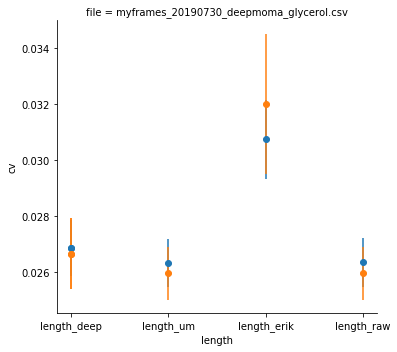

In [632]:
g = sns.FacetGrid(deepdf, col="file", size=5,hue="step",col_wrap=3,sharey=False)
#snspl = g.map(plt.errorbar, "length", "gamma", "egamma",fmt='o')
snspl = g.map(plt.errorbar, "length", "cv", "ecv",fmt='o')
snspl.savefig('gly_deep_cv.png')

In [605]:
deepdf.loc[deepdf['length']=='length_um']

,ll,ml,gamma,sl2,sm2,eml,egamma,esl2,esm2,step,...,file,length,mincel,filt,tau,etau,sm,esm,cv,ecv
12,1.893621,0.011273,0.010115,1.338386e-07,0.000373,0.000269,0.001578,1.503942e-08,0.000015,3.0,...,myframes_20190730_deepmoma_glucose.csv,length_um,12,0,98.859766,15.422820,0.019307,0.000380,0.024225,-0.000818
33,1.749424,0.011195,0.010501,1.378017e-07,0.000371,0.000228,0.001448,1.453832e-08,0.000016,4.0,...,myframes_20190730_deepmoma_glucose.csv,length_um,12,0,95.225427,13.128365,0.019262,0.000426,0.024209,-0.000638
1544,1.587441,0.005247,0.005153,3.649003e-08,0.000406,0.000182,0.000773,4.084690e-09,0.000021,4.0,...,myframes_20190730_deepmoma_glycerol.csv,length_um,12,0,194.045320,29.111515,0.020152,0.000529,0.025976,-0.000946
1548,1.747692,0.005156,0.006597,4.718743e-08,0.000388,0.000176,0.001003,5.697363e-09,0.000018,3.0,...,myframes_20190730_deepmoma_glycerol.csv,length_um,12,0,151.574877,23.045523,0.019694,0.000463,0.026337,-0.000862


# 

In [642]:
    file_to_analy = '/scicore/home/nimwegen/fiori/MoMA_predictions/collected_and_filtered_glycerole.csv'
    step = int(3)
    fil = int(10)
    leng = 'length_um'
    dglu = pd.read_csv(file_to_analy)
    dglu =  dglu.loc[dglu['discard_top']!=1] 
    dglu = dglu.loc[dglu['end_type']=='div']
    dft = rl.give_unique_dataset(dglu,step,fil)
    _,in_dic = rl.build_data_strucutre(dft,leng,1)
    boundary = [(1e-10,None),(1e-5,None),(1e-10,None),(1e-10,None)]
    m,g,s,e =[1.1418e-02,1.6093e-02,2.3630e-07,3.4849e-04]
    r = np.random.rand(4)*np.random.choice((-1,1),4)*0.5 #50% max var 
    mod=mn.minimize_lengths(free={'sl2':s+s*r[0],'gamma':g+g*r[1],'sm2':e+e*r[2],'mlam':m+m*r[3]},fixed={},boundary=boundary)
    

In [278]:
dfd.cell.unique().shape

(116,)

In [61]:
dfd = pd.read_csv('/scicore/home/nimwegen/fiori/deep_moma_data/myframes_20190730_deepmoma_glucose.csv')
dfl = pd.read_csv('/scicore/home/nimwegen/fiori/deep_moma_data/myframes_20190730_legacymoma_glucose.csv')
dfd = rl.give_good_structure(dfd)
dfl = rl.give_good_structure(dfl)

In [ ]:
dft = rl.give_unique_dataset(df,step,fil)
_,in_dic = rl.build_data_strucutre(dft,leng,1)

In [681]:
    elrat = dfl.groupby('cell').apply(lambda x:\
                                     linregress(x['time_sec'],np.log(x['{}'.format(leng)])).slope)

In [710]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [714]:
dfl.cell.unique().shape

(107,)

In [1001]:
rl.long_corr_in_data(dfl,'length_um',2)

(array([[3.05501079e-01, 9.30000000e+01],
        [1.76651788e-03, 8.00000000e+01]]), 0.17270662719319754)

In [127]:
def ornstein_uhlenbeck(mlam,gamma,sl2,shape=(1,1000),dtsim=1):
    "Create ou model of shape (#ncel,#length_cell) with sampling dtsim"
    mat = np.zeros(shape)
    sig = np.sqrt(sl2)
    dW = np.random.normal(loc=mat,scale=np.sqrt(dtsim))
    add = sig*dW*dtsim
    mat[:,0]=add[:,0]+mlam
    for k in range(1,shape[1]):
        mat[:,k]=mat[:,k-1]-gamma*(mat[:,k-1]-mlam)*dtsim+add[:,k]
    return mat

def adder(V0,W,DV,prin=False,dt_sim=1):
    """V0 initial volume DV added volume (equal to V0 in stationary) W OU process"""
    #assert W.shape[0]==1
    W = W.reshape(-1)
    x0=V0
    integ = []
    j=0
    while True:
        W = np.insert(W,0,0)
        try:
            #Find first index which fulfill condition
            exp = x0*np.exp(np.cumsum(W*dt_sim))
            ind = np.where(exp-x0<DV)[0][-1]+1
            if W.shape[0]==1:break
        except IndexError:
            break
        #Randomly choose if take first smaller or first larger which statistfy cond
        ind += np.random.choice([0,1])
        integ.append(exp[:ind])
        W= W[ind:]
        x0=integ[-1][-1]/2
    #return integ
    #to_print = np.array([k[-1] for k in integ])
    #if prin: print('added length:',np.mean(to_print),'+/-',np.std(to_print)/np.sqrt(len(to_print)))
    return integ[:-1]

def smilar_frame(mlam,gamma,sl2,sm2,V0,DV,shape=(1,1000),dtsim=1,prin=False):
    """From  OU create a dataframe with same shape as biological data (divison at twice the size).. Consider also asymmetric division """
    explen = []; lane_ID=[]; parent_ID=[]; id_n=[-1]; time_sec=[]; df=[]
    W = ornstein_uhlenbeck(mlam,gamma,sl2,shape,dtsim) # create elongation rate dynamics
    V = np.zeros_like(W)
    V[:,0] = V0
    for i in range(W.shape[0]):
        X = adder(V0,W[i,:],DV,prin,dtsim)
        for j,k in enumerate(X):
            lane_ID = ['{}'.format(i)]*int(len(k))
            parent_ID = ['{}'.format(id_n[-1])]*int(len(k))
            id_n = ['{}'.format(j)]*int(len(k))
            explen= np.exp(np.random.normal(np.log(k),np.sqrt(sm2)))
            df.append(pd.DataFrame({'leng':explen,'lane_ID':lane_ID,'parent_id':parent_ID, 'id':id_n}))
    df = pd.concat(df,ignore_index=True)
    df['time_sec'] = np.arange(0,df.shape[0]*dtsim,dtsim)*60
    df['cell'] = df['lane_ID']+df['id']
    return df

In [129]:
A  = rl.adder(2,X,2)

In [121]:
R = [ linregress(range(k.shape[0]),np.log(k)).slope for k in A]

In [126]:
A

[array([2.        , 2.02267467, 2.04560614, 2.06879833, 2.09225351,
        2.11597385, 2.13996246, 2.16422195, 2.18875784, 2.21357271,
        2.23866983, 2.26405105, 2.28971933, 2.31567972, 2.34193575,
        2.36848941, 2.39534511, 2.42250543, 2.4499735 , 2.47775253,
        2.50584754, 2.53426011, 2.56299432, 2.59205393, 2.62144301,
        2.65116533, 2.6812242 , 2.71162276, 2.74236542, 2.77345872,
        2.80490462, 2.83670556, 2.86886689, 2.90139424, 2.93428987,
        2.96755561, 3.00119827, 3.03522189, 3.06963038, 3.10442958,
        3.13962425, 3.17521661, 3.21121375, 3.24761995, 3.28443973,
        3.32167613, 3.35933599, 3.39742272, 3.43594188, 3.47489642,
        3.51429445, 3.55413929, 3.59443726, 3.63519163, 3.6764064 ,
        3.7180862 , 3.76023702, 3.80286654, 3.84597802, 3.88957882,
        3.93367412, 3.97827044]),
 array([1.98913522, 2.01168791, 2.03449568, 2.0575635 , 2.08089224,
        2.10448432, 2.12834424, 2.15247506, 2.17687969, 2.20156212,
        2.2265

In [137]:
imp.reload(rl)

<module 'recursive_lengths' from '/scicore/home/nimwegen/fiori/only_length_optimization/moma_predictions/recursive_lengths.py'>

In [138]:

a = rl.smilar_frame(0.011459466330689765,0.01592933073533354,2.337170589189002e-07,0.00034218716222503336,1.970,1.97,shape=(2,10000))
a = rl.genalogy(a)
elrat = a.groupby('cell').apply(lambda x:linregress(x['time_sec'],np.log(x['{}'.format('leng')])).slope*60)
rl.corr_par(a,elrat)

(0.4336781865438972, 334)

In [139]:
rl.long_corr_in_data(a,'leng',1)

(array([[  0.43367819, 334.        ]]), 0.19907438610453906)

In [145]:
a = rl.smilar_frame(0.011209049438460635, 0.01028684743481966, 1.331466836100101e-07,0.0003701397092470169,1.970,1.97,shape=(2,10000))
a = rl.genalogy(a)
rl.long_corr_in_data(a,'leng',1)

(array([[  0.56855633, 321.        ]]), 0.19080662769854434)

In [320]:
1/0.012

83.33333333333333

In [319]:
_,in_dic = rl.build_data_strucutre(dfl,'length_um',1)

In [322]:
    boundary = [(1e-10,None),(1e-5,None),(1e-10,None),(1e-10,None)]
    m,g,s,e,a =[in_dic['s'][1,0],0.01,2.3630e-07,in_dic['sm2'],in_dic['sd2']]
    r = np.random.rand(5)*np.random.choice((-1,1),5)*0.5 #50% max var 
    #mod=mn.minimize_lengths(free={'sl2':s+s*r[0],'gamma':g+g*r[1],'sm2':e+e*r[2],'sd2':a+a*r[4],'mlam':m+m*r[3]},fixed={},boundary=boundary)
    mod=mn.minimize_lengths(free={'sl2':s+s*r[0],'gamma':g+g*r[1],'sm2':e+e*r[2],'mlam':m+m*r[3]},fixed={'sd2':a},boundary=boundary)
    bestpar =mod.minimize(in_dic=in_dic,numerical=False,fun=rl.grad_obj_wrap)

# THEOOO

In [333]:
import GPy

In [324]:
dft = pd.read_csv('/scicore/home/nimwegen/gervais/MoM_StatPhase/GAUSSIAN_SMOOTHING/length_moma_ATHOS_1342.csv')


In [383]:
idx = dft.cell.unique()

In [385]:
idx.shape

(1629,)

In [388]:
dfs  =dft.loc[(dft['cell']==idx[0])|(dft['cell']==idx[1])|(dft['cell']==idx[2])|(dft['cell']==idx[4])|(dft['cell']==idx[24])|(dft['cell']==idx[43])|(dft['cell']==idx[14])]


In [390]:
dfs[['cell','length_moma']].to_

,cell,length_moma
0,20191018_0_10_72,1.950
1,20191018_0_10_72,1.885
2,20191018_0_10_72,1.885
3,20191018_0_10_72,1.950
4,20191018_0_10_72,1.885
5,20191018_0_10_72,1.885
6,20191018_0_10_72,1.950
7,20191018_0_10_72,1.885
8,20191018_0_10_72,1.885
9,20191018_0_10_72,1.885


In [371]:
X = dft.loc[dft['cell']=='20191018_0_10_74']['length_moma'].dropna().values

In [365]:
XTP =  dft.loc[dft['cell']=='20191018_0_10_74']['length_moma_pred'].dropna().values

In [374]:
XTP=XTP-MX

In [372]:
MX=np.mean(X)

In [373]:
X = X- np.mean(X)

In [350]:
T = np.arange(0,X.shape[0]*12,12)[:,None]

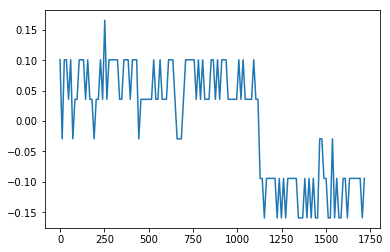

In [351]:
plt.plot(T.reshape(-1),X.reshape(-1))

In [352]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.,)
m = GPy.models.GPRegression(T,X[:,None],kernel)

In [378]:
GPy.kern.RBF?

In [358]:
XP = m.predict_noiseless(T)

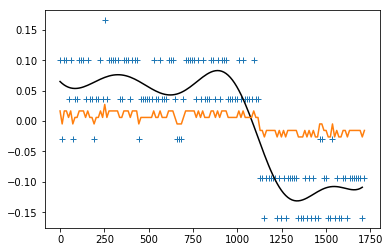

In [376]:
plt.plot(T.reshape(-1),X.reshape(-1),'+')
plt.plot(T.reshape(-1)[:-1],XTP.reshape(-1)[::3],'-k')

plt.plot(T.reshape(-1),XP[0].reshape(-1),'-')

In [ ]:
5.09495718e+01, 3.03129642e+00, 9.92045181e-04